# Sky coordinate DSLR aperture photometry yielding untransformed magnitudes
### Uses Python 3, astropy, matplotlib, PythonPhot, PhotUtils
### Assumes a plate-solved image for RA/Dec determination

## Definitions

### Imports

In [283]:
import os
from random import random
# TODO: shouldn't need ordered dictionary now either
from collections import OrderedDict

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.visualization import astropy_mpl_style

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
plt.style.use(astropy_mpl_style)
%matplotlib inline

from PythonPhot import aper

import requests, math, glob

from photutils import DAOStarFinder

from astropy.stats import mad_std

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from photutils import aperture_photometry, CircularAperture

import warnings
warnings.filterwarnings('ignore')

### Functions

#### RA and Dec for a list of stars

In [338]:
def get_ra_and_dec(stars, maglimit):
    result = []
    for star in stars:
        vsp_template = 'https://www.aavso.org/apps/vsp/api/chart/?format=json&fov=10&star={}&maglimit={}'
        query = vsp_template.format(star, maglimit)
        record = requests.get(query).json()
        # assume that first element corresponds to the star
        if len(record["photometry"]) != 0 and record["photometry"][0]["auid"] == record["auid"]:
            bands = record["photometry"][0]["bands"]
        else:
            bands = []
        result.append({"star":record["star"], "ra":record["ra"], "dec":record["dec"], "bands":bands})
    return result

#### Extract all sources from image

In [170]:
def extract_all_sources(fits_path, fwhm, source_snr=20):
    hdulist = fits.open(fits_path)
    data = hdulist[0].data.astype(float)
    header = hdulist[0].header
    wcs = WCS(header)
    bkg_sigma = mad_std(data)    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*bkg_sigma)    
    sources = daofind(data)
    return sources, wcs

#### Convert RA and Dec to local coordinates

In [119]:
def get_local_coords(ra_decs, wcs, radius=4):
    local_position_map = OrderedDict()
    for ra_dec in ra_decs:
        star_coord = SkyCoord("{} {}".format(ra_dec['ra'], ra_dec['dec']), unit=(u.hourangle, u.deg))
        xy = SkyCoord.to_pixel(star_coord, wcs=wcs, origin=1)
        x = xy[0].item(0)
        y = xy[1].item(0)
        for source in sources:
            if(source['xcentroid']-radius <= x <= source['xcentroid']+radius) and \
                source['ycentroid']-radius <= y <= source['ycentroid']+radius:
                local_position_map[ra_dec["star"]] = (x, y)
    return local_position_map

#### Extract reference (check, comparison) magnitude map from ordered star information list

In [330]:
def get_ref_mags_for_band(star_info_list, desired_band):
    mags = {}
    # target star's band list will be empty
    for info in star_info_list:
        for band in info["bands"]:
            #print("{}: {}".format(info["star"], band))
            if band["band"] == desired_band:
                mags[info["star"]] = band["mag"]
                break
    return mags

#### Photometry of a list of FITS files, creating a table of times and instrumental magnitudes

In [353]:
def multi_file_photometry(fits_root, fits_files, data_index, coords, dataframe, 
                          aperture_radius, inner_sky_radius, outer_sky_radius, 
                          gain=1, zeropoint=0, suffix='.fit'):
    
    for fits_file in fits_files:
        fits_file_path = os.path.join(fits_root, fits_file)
        hdus = fits.open(fits_file_path)
            
        instr_mags = []
        for x, y in coords:
            time, mag = aperture_photometry(hdus[data_index], x, y, 
                                            aperture_radius, inner_sky_radius, outer_sky_radius,
                                            gain, zeropoint)
            instr_mags.append(mag)
        
        dataframe[fits_file[0:fits_file.rindex(suffix)]] = [time] + instr_mags  

#### Single image+coordinate photometry, returning a time and instrumental magnitude
##### Invoked by multi_file_photometry()

In [354]:
def aperture_photometry(hdu, x, y, 
                        aperture_radius, inner_sky_radius, outer_sky_radius, 
                        gain, zeropoint):

    image_data = hdu.data
    time = hdu.header[time_name]
        
    mag, magerr, flux, fluxerr, sky, skyerr, badflag, outstr = \
                aper.aper(image_data, x, y, phpadu=gain, 
                          apr=aperture_radius, zeropoint=zeropoint,
                          skyrad=[inner_sky_radius, outer_sky_radius], 
                          exact=True)

    return time, mag[0]

#### Display an image with target and reference stars annotated, to sanity check local coordinates

In [177]:
def show_image(image_data, coord_map, aperture_size, annotate=True, vmin=10, vmax=200, figx=20, figy=10):
    fig = plt.figure(figsize=(figx, figy))
    plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
    plt.gca().invert_yaxis()
    plt.colorbar()

    if annotate:
        for designation in coord_map:
            xy = coord_map[designation]
            annotate_image(fig.axes[0], designation, xy, aperture_size)
    
    plt.show()

#### Annotate plot axis with coordinate positions and designations
#### Invoked by show_image()

In [178]:
def annotate_image(axis, designation, xy, aperture_size):
    axis.plot(xy[0], xy[1], 'o', markersize=aperture_size, 
              markeredgecolor='r', markerfacecolor='none', 
              markeredgewidth=2)
    
    offsetbox = TextArea(designation, minimumdescent=False)

    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(-20, 40+random()*10-10),
                        xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
    
    axis.add_artist(ab)        

#### Compute standardised magnitudes given a data frame of all instrumental magnitudes, a list of all star names, a list of row names of interest (e.g. stk-median-g*) in the instrumental magnitude data frame, and a dictionary of comparison star magnitudes

In [329]:
def standardised_magnitudes(instr_mag_df_trans, star_names, row_names, catalog_mags):
    # exclude target star and check star to get list of possible comparison star names
    comp_names = star_names[2:]
    # obtain available comparison star names and magnitudes, ignoring any star not in catalog
    avail_comp_names = [name for name in comp_names if name in catalog_mags.keys()]
    avail_comp_mags = [catalog_mags[name] for name in comp_names if name in catalog_mags.keys()]
    target_name = star_names[0]
    #print(avail_comp_names, avail_comp_mags, target_name)
    std_mags = np.array([])
    for row_name in row_names:
        # get instrumental magnitudes for the current row of data and compute
        # standardised magnitude of the target star
        comp_instr_mags = [instr_mag_df_trans.loc[row_name][comp_name] for comp_name in avail_comp_names]
        target_mag = standardised_magnitude(instr_mag_df_trans.loc[row_name][target_name],
                                            np.array(comp_instr_mags),
                                            np.array(avail_comp_mags))
        # collect standardised magnitudes for each row
        std_mags = np.append(std_mags, target_mag)
    # TODO: also compute/return check star mags and look at std error; is that what spreadsheet uses?
    return std_mags

#### Compute standardised magnitude given target's instrumental magnitude, a numpy array of comparison star instrumental magnitudes and catalog comparison star magnitudes

In [324]:
def standardised_magnitude(target_instr_mag, comp_instr_mags, catalog_comp_mags):
    deltas = target_instr_mag - comp_instr_mags
    mags = deltas + catalog_comp_mags
    return mags.mean()

### Write AAVSO Extended Upload Format file suitable for upload to WebObs
* the results parameter is a list of tuples containing jd, mag, mag_err, band, check, check_instr_mag for each photometry result

In [397]:
def write_webobs_file(path, obscode, cal_software, target, check, airmass, results, chart_id, comment):
    header_template = """#TYPE=EXTENDED
#OBSCODE={0}
#SOFTWARE={1}, Python scripts, Jupyter notebook
#DELIM=,
#DATE=JD
#OBSTYPE=DSLR
#NAME,DATE,MAG,MERR,FILT,TRANS,MTYPE,CNAME,CMAG,KNAME,KMAG,AMASS,GROUP,CHART,NOTES
"""
    if type(airmass) is float:
        airmass = "{0:1.6f}".format(airmass)
    result_template = "{0},{1:1.6f},{2:1.6f},{3:1.6f},{4},NO,STD,ENSEMBLE,NA,{5},{6:1.6f},{7},NA,{8},{9}\n"
    with open(path, "w") as webobs:
        webobs.write(header_template.format(obscode, cal_software))
        for result in results:
            jd, mag, mag_err, band, check_instr_mag = result
            webobs.write(result_template.format(target, jd, mag, mag_err, band, check, check_instr_mag,
                                                airmass, chart_id, comment))

## Inputs
### Change these to suit your environment

#### File settings

In [195]:
# Output file directory
output_file_root = "/Users/david/aavso/dslr-photometry/working"

# WebObs file
webobs_file = "webobs.csv"

# Instrumental magnitude output file path
instr_mag_csv_file = "instr_mags.csv"

# FITS file directory
fits_root = "/Users/david/aavso/dslr-photometry/working"

# Plate-solved FITS file name
wcs_file = "stk-median-g1-wcs.fit"

# B, G, and R FITS file prefixes to identify files,
# e.g. stk-median-g matches stk-median-g1.fit, stk-median-g2.fit, ... 
fits_prefixes = ["stk-median-b", "stk-median-g", "stk-median-r"]

# FITS file data HDU index
data_index = 0

# Time column name
time_name = "JD"

#### Names or AUIDs for target and comparison stars

In [196]:
names = ["eta Car","000-BBR-533","000-BBR-603","000-BBS-066","000-BBR-573","000-BBR-998","000-BBR-795","000-BBR-563"]

#### Magnitude limit for comparison star lookups

In [197]:
maglimit = 7

#### Aperture radii and gain

In [198]:
# FWHM (e.g. from PSF in IRIS)
fwhm = 6

# Aperture radii
measurement_aperture = 9
inner_sky_annulus = 12
outer_sky_annulus = 20

# ph/ADU
# Note: PythonPhot's aperture photometry function takes a phadu parameter.
# Assumption: this is photons/ADU or e-/ADU, i.e. gain.
gain=1.67

## Outputs

### Obtain RA and Dec for selected AUIDs

In [339]:
target_comp_ra_dec = get_ra_and_dec(names, maglimit=maglimit)

In [340]:
# Question: why does 000-BBR-563 have no bands?
target_comp_ra_dec

[{'star': 'eta Car', 'ra': '10:45:03.54', 'dec': '-59:41:04.0', 'bands': []},
 {'star': '000-BBR-533',
  'ra': '10:35:35.30',
  'dec': '-57:33:27.5',
  'bands': [{'band': 'V', 'mag': 4.45, 'error': 0.1},
   {'band': 'U', 'mag': 7.86, 'error': 0.173},
   {'band': 'B', 'mag': 6.07, 'error': 0.141},
   {'band': 'J', 'mag': 1.762, 'error': 0.338},
   {'band': 'H', 'mag': 1.024, 'error': 0.232},
   {'band': 'K', 'mag': 0.842, 'error': 0.268}]},
 {'star': '000-BBR-603',
  'ra': '10:43:32.29',
  'dec': '-60:33:59.8',
  'bands': [{'band': 'V', 'mag': 4.57, 'error': 0.1},
   {'band': 'U', 'mag': 8.15, 'error': 0.173},
   {'band': 'B', 'mag': 6.28, 'error': 0.141},
   {'band': 'J', 'mag': 1.575, 'error': 0.29},
   {'band': 'H', 'mag': 0.727, 'error': 0.27},
   {'band': 'K', 'mag': 0.453, 'error': 0.314}]},
 {'star': '000-BBS-066',
  'ra': '11:12:36.01',
  'dec': '-60:19:03.5',
  'bands': [{'band': 'V', 'mag': 4.6, 'error': 0.1},
   {'band': 'U', 'mag': 5.2, 'error': 0.173},
   {'band': 'B', 'mag

### Extract all sources from plate-solved image

In [341]:
sources, wcs = extract_all_sources(wcs_file, fwhm=fwhm)
sources

#### Convert RA and Dec to local coordinates

In [344]:
position_map = get_local_coords(target_comp_ra_dec, wcs)
position_map

OrderedDict([('eta Car', (2281.2138840496655, 1414.872228620236)),
             ('000-BBR-533', (1564.1809432939033, 1801.7448686185137)),
             ('000-BBR-603', (2570.3681490033005, 1490.7120001280882)),
             ('000-BBS-066', (2603.7564852723444, 299.96914422122893)),
             ('000-BBR-573', (2105.5250683505483, 1674.2897248509514)),
             ('000-BBR-998', (3115.7851797336907, 537.964495374689)),
             ('000-BBR-795', (1492.7927611311118, 1042.4262301298797)),
             ('000-BBR-563', (1955.313874519899, 1726.4820676277566))])

### Find B, G, R files in the FITS file directory

In [345]:
files = os.listdir(fits_root)

fits_files = []
for fits_prefix in fits_prefixes:
    fits_files += sorted([file for file in files if fits_prefix in file and file.find("wcs") == -1])

### Aperture location sanity check by visual inspection
#### Arbitrarily choose the first G FITS file

stk-median-g1.fit


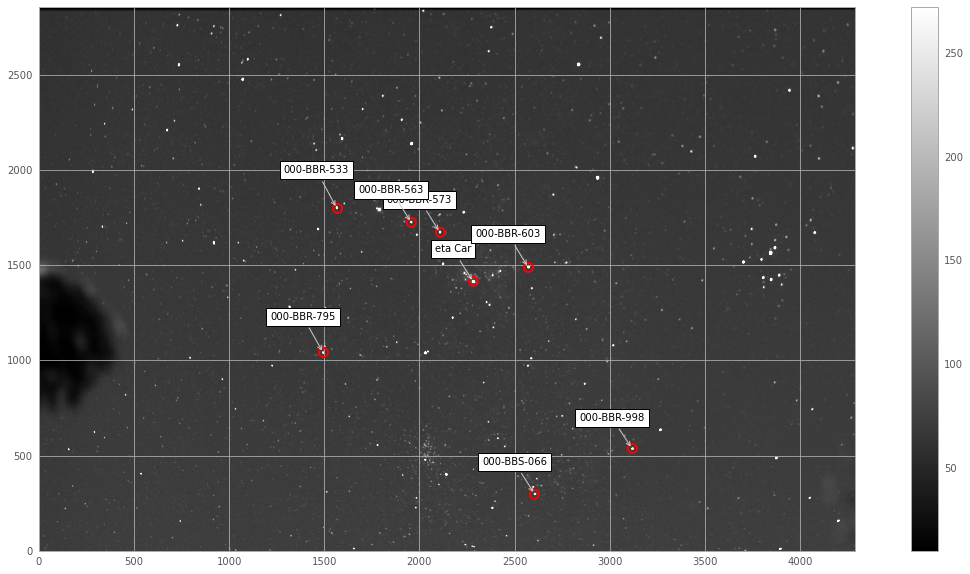

In [346]:
fits_file = fits_files[5]
print(fits_file)
hdus = fits.open(os.path.join(fits_root, fits_file))
image_data = hdus[data_index].data

median = np.median(image_data)
show_image(image_data, position_map, measurement_aperture, annotate=True, vmin=10, vmax=median*4)

### Aperture photometry, yielding instrumental magnitudes

In [347]:
# Create empty table with time and object headers
pd.options.display.float_format = '{:,.6f}'.format
instr_mag_df = pd.DataFrame()
names = [name for name in position_map]
instr_mag_df['name'] = [time_name] + names
instr_mag_df.set_index('name', inplace=True)

In [355]:
# Carry out photometry on B, G, R FITS files, yielding instrumental magnitudes
positions = position_map.values()

multi_file_photometry(fits_root, fits_files, data_index, positions, instr_mag_df, 
                      measurement_aperture, inner_sky_annulus, outer_sky_annulus, gain)

In [398]:
# Save photometry table as CSV
instr_mag_csv_path = os.path.join(output_file_root, instr_mag_csv_file)
instr_mag_df.T.to_csv(instr_mag_csv_path)

# Display photometry table
instr_mag_df.T

NameError: name 'output_file_root' is not defined

### Differential Photometry and Standarised Magnitude

In [357]:
b_row_names = [row_name for row_name in instr_mag_df.T.index if "-b" in row_name]
g_row_names = [row_name for row_name in instr_mag_df.T.index if "-g" in row_name]
r_row_names = [row_name for row_name in instr_mag_df.T.index if "-r" in row_name]

In [358]:
catalog_v_mags = get_ref_mags_for_band(target_comp_ra_dec, "V")
tg = standardised_magnitudes(instr_mag_df.T, names, g_row_names, catalog_v_mags)
tg.mean(), np.median(tg), tg.std()

(3.9446040863894964, 3.94645320124816, 0.007614792898697641)

In [359]:
catalog_b_mags = get_ref_mags_for_band(target_comp_ra_dec, "B")
tb = standardised_magnitudes(instr_mag_df.T, names, b_row_names, catalog_b_mags)
tb.mean(), np.median(tb), tb.std()

(4.652646323105369, 4.660683960709565, 0.01588090848406482)

In [396]:
obscode = "BDJB"
cal_software = "IRIS"
target = names[0]
check = names[1]
airmass = "NA" # TODO: compute (look at AAVSO spreadsheet)
chart_id = "X15962DX"
comment = "Canon 1100D; 100mm; ISO 100; f2.0; 5 sec x 20 images median stacked in groups of 5"

jd = instr_mag_df.T.iloc[0]["JD"]
check_instr_b = instr_mag_df.T.loc[b_row_names][check].mean()
check_instr_g = instr_mag_df.T.loc[g_row_names][check].mean()

results = [(jd, tb.mean(), tb.std(), "TB", check_instr_b),
           (jd, tg.mean(), tg.std(), "TG", check_instr_g)]

webobs_path = os.path.join(output_file_root, webobs_file)
write_webobs_file(webobs_file, obscode, cal_software, target, check, airmass, results, chart_id, comment)

In [372]:
# Questions:
# - is mean or median best per T[BGR] row?
# - std() or some other std dev function (e.g. population vs sample)
# - how to compute R; use catalog B-V, V-R? may just want to report TG, TB
# - is there a role for linear regression here or only for transformation coefficients?
# - can/should we do airmass correction independent of transformation?

## Links
* http://docs.astropy.org/en/stable/io/fits
* http://docs.astropy.org/en/stable/generated/examples/io/plot_fits-image.html
* http://www.astropy.org/astropy-tutorials/FITS-images.html
* https://github.com/djones1040/PythonPhot
* https://www.aavso.org/photometry-astropy-photutils-reviewers-please
* https://www.aavso.org/aavso-extended-file-format